In [2]:
import numpy
import math

from scipy.stats import norm, gamma, kstest

from statsmodels.stats.proportion import proportion_confint
from matplotlib import pyplot

from tqdm import tqdm

from collections import namedtuple

numpy.random.seed(42)

In [3]:
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert): 
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in pyplot.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'
    
    old_cycle = pyplot.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    pyplot.rcParams.update(update_dict)
    pyplot.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = pyplot.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    pyplot.rcParams['legend.edgecolor'] = lec

In [4]:
inverse_plot_colorscheme()

# Критерии однородности и критерий Колмогорова-Смирнова

## Критерии однородности

> **Задача**
>
> Первая выборка — артериальное давление контрольной группы (набора пациентов, которым вводилось плацебо). Вторая выборка — артериальное давление тестовой группы (набора пациентов, которым вводилось лекарство). Нужно проверить, влияет ли вводимое лекарство на артериальное давление?

Конечно, мы можем решать такую задачу с помощью T-test. Но артериальное давление от введения лекарства по некоторым разрезам пациентов может стать выше, по некоторым ниже, и среднее может не измениться. Что же делать?

Мы можем воспользоваться критерием однородности. Он позволяет проверить, действительно ли наблюдаемые выборки получены из одного и того же неизвестного распределения. Давайте формализуем постановку задачи критерия однородности. 

Пусть есть 2 реализации выборки: 
- $x_1, \dots, x_n$: реализация выборки $X$ случайных величин $X_1, \dots, X_n$, каждая из которых распределена как $\mathcal{P}_X$.
- $y_1, \dots, y_m$: реализация выборки $Y$ случайных величин $Y_1, \dots, Y_m$, каждая из которых распределена как $\mathcal{P}_Y$.

Критерий согласия проверяет равенство истинных распределений:

 - $H_0: \mathcal{P}_X = \mathcal{P}_Y$
 - $H_1: \mathcal{P}_X \neq \mathcal{P}_Y$.
 
Либо, [аналогично](https://stats.stackexchange.com/questions/136658/why-does-a-cumulative-distribution-function-cdf-uniquely-define-a-distribution), равенство их функций распределения:

 - $H_0: F_X = F_Y$
 - $H_1: F_X \neq F_Y$.

## Критерий Колмогорова-Смирнова

### Два вида однородности


При проверке гипотезы однородности двух выборок $X_1, X_2, \dots, X_n$ и $Y_1, Y_2, \dots, Y_m$ стоит понять, с чем мы имеем дело: реализациями независимых между собой случайных величин или парными повторными наблюдениями.

В качестве примера можем рассмотреть другую постановку задачи определения влияния лекарства на артериальное давление пациентов. 

Давайте сравним две постановки эксперимента:
1. Первая выборка — артериальное давление контрольной группы (набора пациентов, которым вводилось плацебо). Вторая выборка — артериальное давление тестовой группы (набора пациентов, которым вводилось лекарство). То есть случайные величины, из которых получена выборка, независимы.
2. Первая выборка — артериальное давление пациентов до введения лекарства. Вторая выборка — артериальное давление тех же самых пациентов после введения лекарства. Cлучайные величины $Х_і$ и $Y_і$ нельзя считать независимыми, так как они относятся к одному и тому же человеку.

Критерий, который мы будем рассматривать в дальнейшем, относится только к первой постановке: все случайные величины $X_1, X_2, \dots, X_n,Y_1, Y_2, \dots, Y_m$ независимы в совокупности. Использовать критерий для парных повторных наблюдений будет ошибкой. В дальнейшем мы обязательно это проверим.



### Придумываем статистику

Постановка задачи очень напоминает простой критерий согласия, который в случае непрерывной функции распределения мы решать уже научились. Давайте вспомним, как же мы строили статистику в критерии согласия Колмогорова?

> В критерии согласия Колмогорова для проверки того, что реализация выборки $x_1, x_2, \dots, x_n$ получена из распределения $\mathcal{P}_0$ с функцией распределения $F_0$ мы использовали статистику $$
    D_n = \underset{x \in \mathbb{R}}{\sup} |\widehat{{F_X}_n}(x) - F_0(x)|
$$ 
> Эта статистика показывала наибольший модуль разности между эмпирической и теоретической функциями распредения.

В критерии однородности вместо известной функции распределения $F_0$ у нас имеется 2 неизвестных функции распределения $F_X$ и $F_Y$, которые мы также можем приблизить эмпирическими функциями распределения $\widehat{{F_X}_n}$ и $\widehat{{F_Y}_m}$. Давайте приспособим статистику из критерия согласия Колмогорова для нашего нового критерия однородности:
$$D_{nm} = \underset{x \in \mathbb{R}}{\sup} |\widehat{{F_X}_n}(x) - \widehat{{F_Y}_m}(x)|,$$ 

где $\widehat{{F_X}_n}(x) = \frac{1}{n}\sum_i[X_i \leqslant x]$, и $\widehat{{F_Y}_m}(x) = \frac{1}{m}\sum_i[Y_i \leqslant x]$.

Очевидно, что слишком большое расстояние будет противоречить гипотезе $H_0$.

In [5]:
x_axis = numpy.arange(start=-3, stop=3, step=0.001)

# аппроксимируем CDF распределения, из которого семплирована наша выборка
# эмпирическая функция распределения:
X = norm().rvs(100)
Y = norm().rvs(100)

emp_cdf_X = []
emp_cdf_Y = []
for x in x_axis:
    cdf_X= sum([int(b <= x) for b in X]) / len(X)
    emp_cdf_X.append(cdf_X)
    cdf_Y = sum([int(b <= x) for b in Y]) / len(Y)
    emp_cdf_Y.append(cdf_Y)

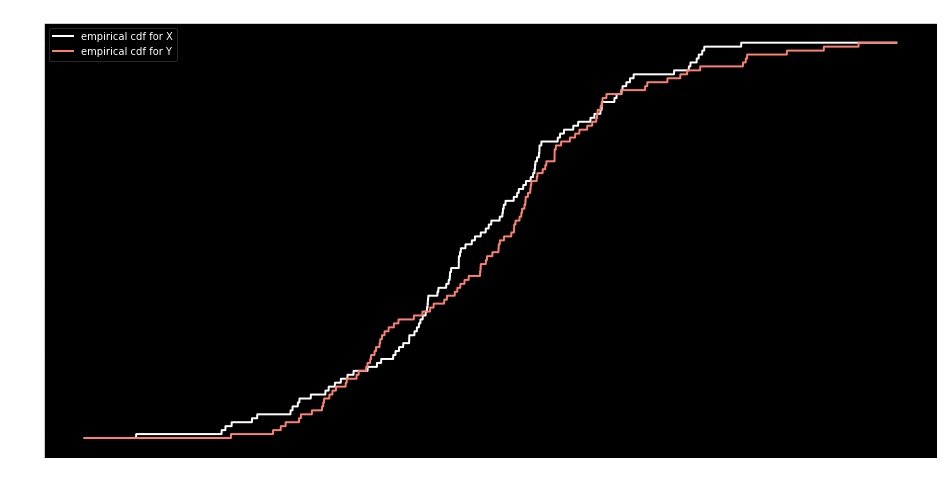

In [6]:
pyplot.figure(figsize=(16, 8))


pyplot.plot(x_axis, emp_cdf_X, color = 'white', linestyle = '-', 
            linewidth=2.0, label='empirical cdf for X')
pyplot.plot(x_axis, emp_cdf_Y, color = 'salmon', linestyle = '-',  
            linewidth=2.0, label='empirical cdf for Y')

pyplot.legend(loc='best')
pyplot.title("Empirical distributions of 2 samples")
pyplot.xlabel("X")
pyplot.ylabel("Cumulative probability")

pyplot.show()

Мы видим на графике эмпирические функции распределения для двух выборок. Как же нам понять, достаточно ли большое расстояние между ними, чтобы мы могли отвергнуть гипотезу о равенстве распределений?

### Распределение статистики

[Н. В. Смирнов](https://ru.wikipedia.org/wiki/%D0%A1%D0%BC%D0%B8%D1%80%D0%BD%D0%BE%D0%B2,_%D0%9D%D0%B8%D0%BA%D0%BE%D0%BB%D0%B0%D0%B9_%D0%92%D0%B0%D1%81%D0%B8%D0%BB%D1%8C%D0%B5%D0%B2%D0%B8%D1%87_(%D0%BC%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D0%BA)) в 1939 году показал, что при выполнении следующих условий:
1. Случайные величины $X_1, X_2, \dots, X_n$ независимы и имеют общую функцию распределения $F_X$.
2. Случайные величины $Y_1, Y_2, \dots, Y_m$ независимы и имеют общую функцию распределения $F_Y$.
3. Функции распределения $F_X$ и $F_Y$ неизвестны, но принадлежат множеству всех **непрерывных функций распределения**.
4. Все компоненты случайного вектора ($X_1, \dots, X_n, Y_1, \dots, Y_m$) **независимы** (условие, которое мы обсудили в разделе "Два вида однородности").

А также при выполнении нулевой гипотезы $H_0: F_X = F_Y$ статистика 

$$\sqrt\frac{nm}{m+n} D_{mn} \stackrel{d}{\rightarrow} \phi,$$ 

где $\phi$ имеет распределение Колмогорова: 

$$F_\phi(x) = \begin{equation*} 
 \begin{cases}
  \sum\limits_{k=-\infty}^ \infty (-1)^k e^{-2k^2 x^2}, &\text{ $ x > 0$}\\
   0, &\text{ $ x < 0$}
 \end{cases}
\end{equation*}$$

Мы знаем статистику и ее распределение при нулевой гипотезе, а это значит, что мы овладели умением проверять гипотезу однородности с помощью нового критерия! 

Если статистика $\sqrt {\frac {nm}{m+n}}D_{mn}$ превышает квантиль распределения Колмогорова $K_{\alpha}$ для заданного уровня значимости $\alpha$ и достаточно больших $n$ и $m$, то нулевая гипотеза $H_0$ об однородности выборок отвергается на уровне значимости $\alpha$.

# Применение критерия Колмогорова-Смирнова на практике

Давайте еще раз сформулируем критерий и условия его применимости простыми словами.

Мы берем наибольшее расхождение между эмпирическими функциями распределений, домножаем его на функцию от размеров выборок и сравниваем с квантилем распределения Колмогорова. Если статистика выше квантиля, то гипотеза отвергается. 

Нужно помнить, что выборки должны быть получены из непрерывных распределений и независимы!

## Достаточный размер выборки для применимости критерия

Давайте теперь попробуем применить вышеописанный критерий. Мы вычитали в книжке М. Б. Лагутина *"Наглядная математическая статистика"*, что критерий можно применять начиная с $n, m \geq 20$. Проверим, так ли это?

Будем решать задачу про влияние лекарства на артериальное давление для независимых выборок, поставленную в начале статьи.

Давайте проведем АА-тест на синтетических данных, которые мы смоделируем из какого-нибудь распределения. Например, возьмем в качестве распределения артериального давления пациентов гамма-распределение с параметрами $(5, 110)$. Нарисуем плотность такого распределения, чтобы вспомнить, как оно выглядит.

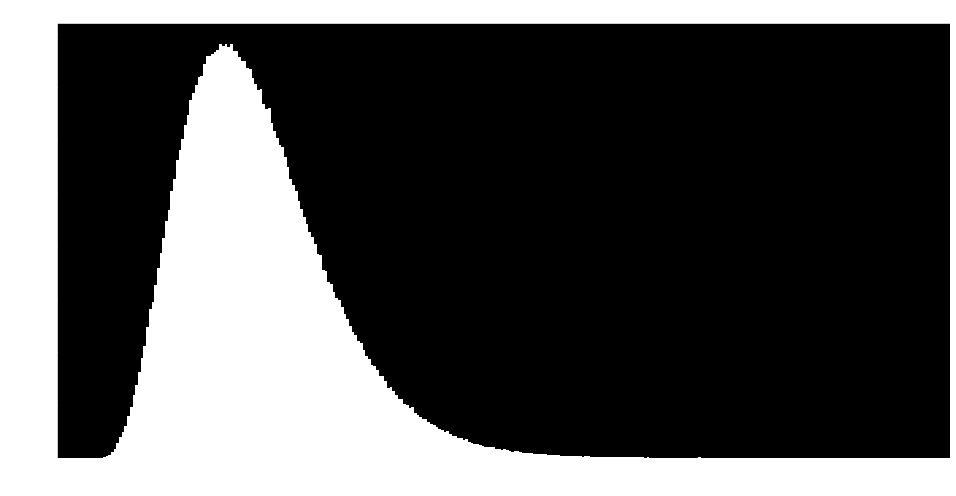

In [7]:
X = gamma(5, 110).rvs(1000000)

pyplot.figure(figsize=(16, 8))

pyplot.hist(X, bins = 300, color = 'white', density= True)
pyplot.title("Gamma (5, 110)")
pyplot.xlabel("Arterial pressure")
pyplot.ylabel("Density")

pyplot.show()

В контрольной группе n пользователей, которым ввели лекарство. В тестовой группе m пользователей, которым ввели плацебо. При этом лекарство воздействия на артериальное давление не имеет.

Проверять будем с помощью функции [kstest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) из пакета scipy.stats.

In [8]:
MonteCarloResults= namedtuple('MonteCarloResults', ['positive_rate',
                                                    'confint_left_bound',
                                                    'confint_right_bound'])

def gen_monte_carlo_exp_for_ks(n, m, alpha, N_runs, latent_dist_X, 
                               latent_dist_Y):
    """
        Функция для проверки критерия Колмогорова-Смирнова
            с помощью метода Монте-Карло
            
        Возвращает долю отвержений гипотезы, и доверительный интервал для этой доли
    
        Параметры:
            - n: размер выборки X
            - m: размер выборки Y
            - alpha: уровень значимости
            - N_runs: число экспериментов в методе Монте-Карло
            - latent_dist_X: распределение выборки X
            - latent_dist_Y: распределение выборки Y
    """
    
    positive = 0
    
    for _ in range(N_runs): 

        X = latent_dist_X.rvs(n)
        Y = latent_dist_Y.rvs(m)
    
        pvalue = kstest(X, Y)[1]
    
        if pvalue<=alpha:
            positive+=1
            
    positive_rate = positive/N_runs
    confint = proportion_confint(count = positive, nobs = N_runs, 
                                 alpha = 0.05, method='wilson')
        
    return MonteCarloResults(**{'positive_rate': positive_rate, 
                                'confint_left_bound': confint[0], 
                                'confint_right_bound': confint[1]})

In [9]:
(positive_rate, 
 confint_left_bound, 
 confint_right_bound) = gen_monte_carlo_exp_for_ks(n = 20, 
                                                   m = 20,
                                                   alpha = 0.05,
                                                   N_runs = 20000,
                                                   latent_dist_X = gamma(5, 110),
                                                   latent_dist_Y = gamma(5, 110))

print('FPR: ', positive_rate)
print('FPR confint: ', (confint_left_bound, confint_right_bound))

FPR:  0.0337
FPR confint:  (0.031287239432944404, 0.036291853392978767)


Видим, что получили $\it{\text{FPR}}$ меньше заявленной $\alpha = 0.05$. Критерий корректен, но заниженный $\it{\text{FPR}}$ — это неприятно: его мощность будет меньше, чем у критерия с $\it{\text{FPR}}$ близким к $\alpha$.

Давайте теперь проверим корректность критерия для стандартного нормального распределения вместо гамма-распределения:

In [10]:
(positive_rate, 
 confint_left_bound, 
 confint_right_bound) = gen_monte_carlo_exp_for_ks(n = 20,
                                                   m = 20,
                                                   alpha = 0.05,
                                                   N_runs = 20000,
                                                   latent_dist_X = norm(),
                                                   latent_dist_Y = norm())

print('FPR: ', positive_rate)
print('FPR confint: ', (confint_left_bound, confint_right_bound))

FPR:  0.0338
FPR confint:  (0.031383645299605384, 0.03639540911910656)


Результат аналогичный: критерий корректен, но доверительный интервал для FPR снова не включает $\alpha$, что является симптомом заниженной мощности.

На самом деле, результат AA-теста не будет зависеть от формы распределений, поэтому для любых $n$ и $m$ мы можем с помощью метода Монте-Карло получить критические значения, которые будут давать $\alpha$, близкую к требуемой: провести большое число экспериментов и взять наиболее экстремальные $\alpha$ процентов. Таким образом, мы создадим свой табличный критерий, который будет корректен для фиксированных $n$ и $m$.

**Вывод: для небольших n и m критерий корректный, но имеет заниженный $\it{\text{FPR}}$.**

Для какого размера выборки пациентов в нашем тесте $n$ и $m$ мы можем применить критерий, чтобы $\it{\text{FPR}}$ слабо отличался от $\alpha$? Давайте вместе узнаем это с помощью метода Монте-Карло!

In [10]:
FPR_list = []

numpy_ceil = numpy.vectorize(math.ceil)

# перебираем размер выборки с логарифмическим шагом
for i in tqdm(numpy_ceil(numpy.geomspace(10, 3000, 10))):  
    mmk_res = gen_monte_carlo_exp_for_ks(n = i, m = i, 
                                         alpha = 0.05,
                                         N_runs = 30000,
                                         latent_dist_X = gamma(1, 2),
                                         latent_dist_Y = gamma(1, 2))
    FPR_list.append([i, mmk_res])

100%|██████████| 10/10 [03:05<00:00, 18.57s/it]


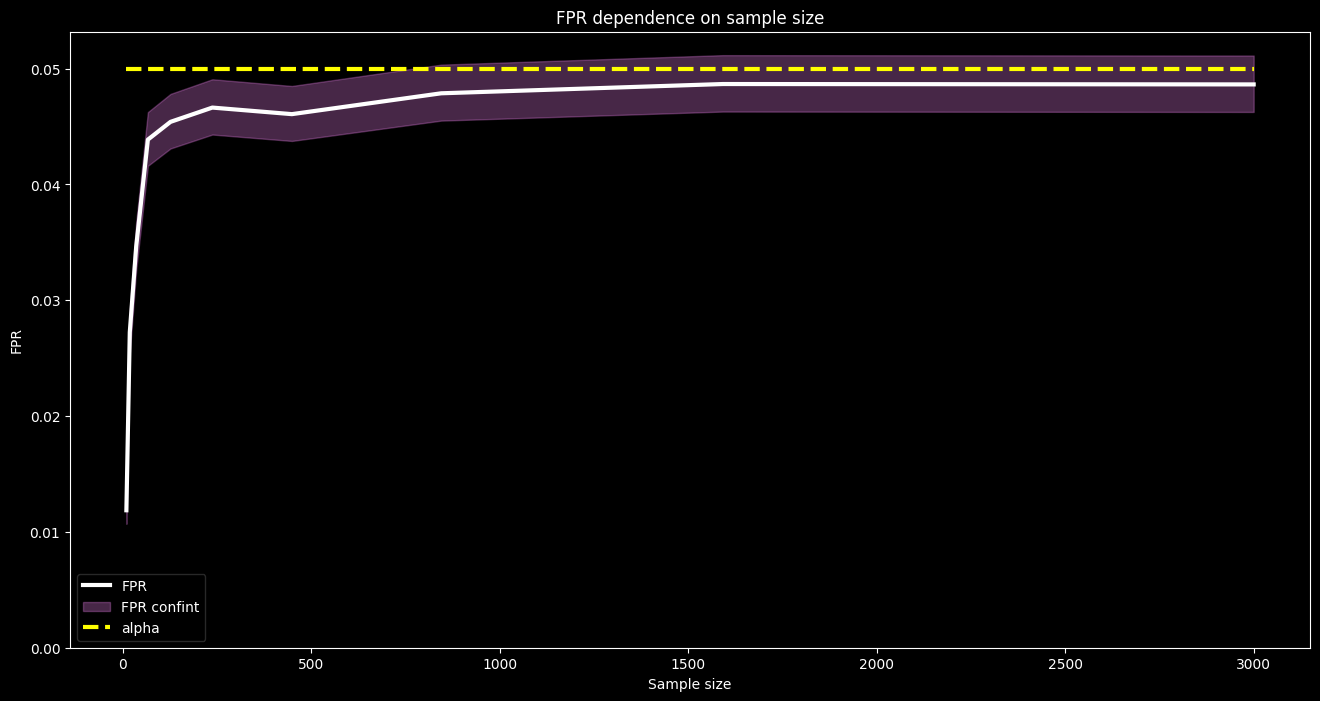

In [14]:
pyplot.figure(figsize=(16, 8))


pyplot.plot([elem[0] for elem in FPR_list], 
            [elem[1].positive_rate for elem in FPR_list], 
            color = 'white', linewidth=3.0, label='FPR')
pyplot.fill_between([elem[0] for elem in FPR_list], 
                    [elem[1].confint_left_bound for elem in FPR_list], 
                    [elem[1].confint_right_bound for elem in FPR_list], 
                    color = 'violet', alpha = 0.3, label='FPR confint')
pyplot.plot([elem[0] for elem in FPR_list], numpy.array([0.05]*len(FPR_list)),
            color = 'yellow', linestyle = 'dashed', 
            linewidth=3.0, label='alpha')

pyplot.legend(loc='best')
pyplot.title("FPR dependence on sample size")
pyplot.xlabel("Sample size")
pyplot.ylabel("FPR")
pyplot.ylim(bottom=0)

pyplot.show()

**Вывод: видим, что начиная с размера выборки ~1000 истинная $\alpha$ попадает в доверительный интервал FPR. Но и для меньшего размера выборки критерий можно использовать: вряд ли нас сильно огорчит FPR в 4.5% вместо требуемых 5%. Для размера выборки менее 50 критерий уже стоит использовать осторожно: FPR может быть значительно ниже заявленного.**

Давайте теперь посмотрим, что происходит с мощностью. Поменяем распределение для второй выборки и посчитаем TPR:

In [54]:
TPR_list = []

for i in tqdm(numpy_ceil(numpy.geomspace(50, 4000, 8))):
    mmk_res = gen_monte_carlo_exp_for_ks(n = i, m = i, 
                                         alpha = 0.05, N_runs = 10000,
                                         latent_dist_X = gamma(1, 2), 
                                         latent_dist_Y = gamma(1.1, 2))
    TPR_list.append([i, mmk_res])

100%|██████████| 8/8 [00:59<00:00,  7.42s/it]


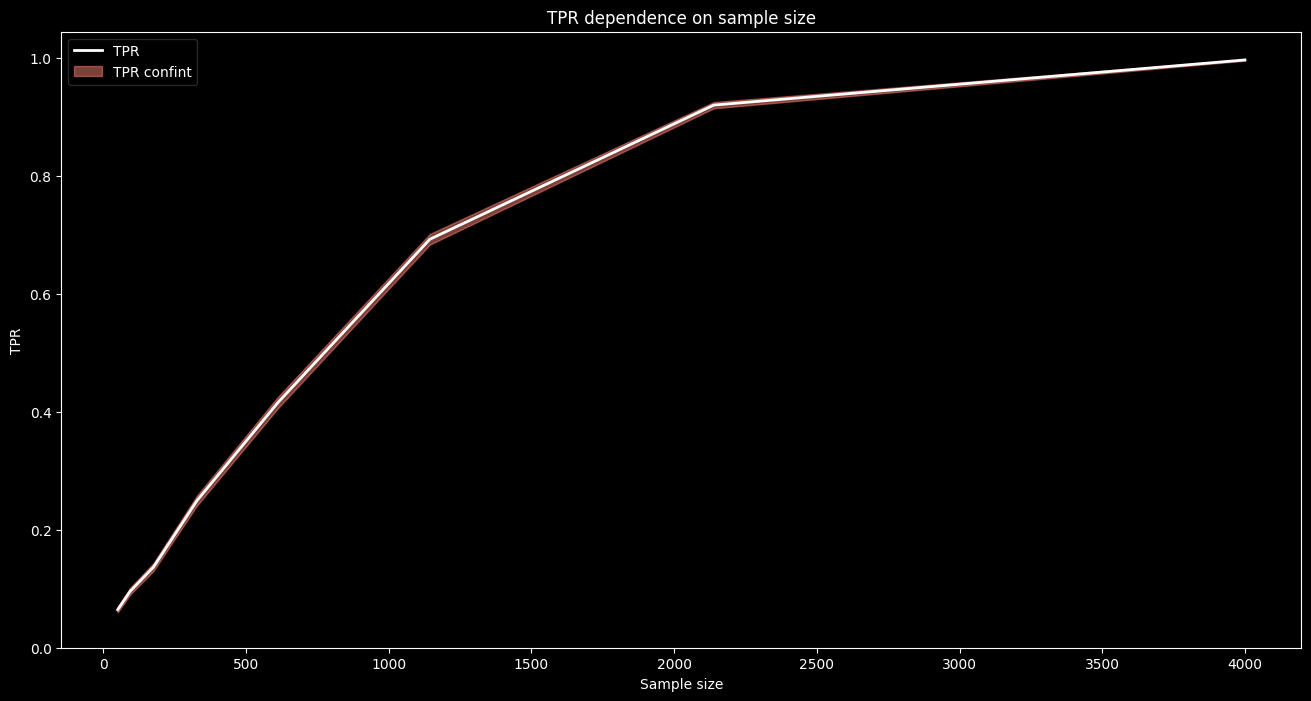

In [57]:
pyplot.figure(figsize=(16, 8))


pyplot.plot([elem[0] for elem in TPR_list],
            [elem[1].positive_rate for elem in TPR_list],
            color = 'white', linewidth=2.0, label='TPR')
pyplot.fill_between([elem[0] for elem in TPR_list],
                    [elem[1].confint_left_bound for elem in TPR_list],
                    [elem[1].confint_right_bound for elem in TPR_list],
                    color = 'salmon', alpha = 0.5, label='TPR confint')

pyplot.legend(loc='best')
pyplot.title("TPR dependence on sample size")
pyplot.xlabel("Sample size")
pyplot.ylabel("TPR")
pyplot.ylim(bottom=0)

pyplot.show()

**Вывод: мощность стремится к 1 с увеличением размера выборки.**

## Зависимые выборки

Что же будет происходить, если условие о независимости выборок не выполняется? Давайте проведем AA-тест и проверим корректность такого критерия.

### Функция для проверки корректности критерия при зависимых выборках

Напишем функцию, которая проверяет корректность критерия с помощью метода Монте-Карло. 

Она будет генерировать из некого "начального" распределения $\mathcal{P}_{\it{\text{init}}}$ выборку размера $n$, а затем накладывать на нее 2 разных выборки из некого распределения "шума": $\mathcal{P}_{\it{\text{noise}}_X}$ и $\mathcal{P}_{\it{\text{noise}}_Y}$. 

То есть: $$ X \sim \mathcal{P}_{init} + \mathcal{P}_{\it{\text{noise}}_X},$$
$$ Y \sim \mathcal{P}_{\it{\text{init}}} + \mathcal{P}_{\it{\text{noise}}_Y}.$$

Если распределения шума одинаковы для обеих выборок ($\mathcal{P}_{\it{\text{noise}}_X}$ = $\mathcal{P}_{\it{\text{noise}}_Y}$), то итоговые выборки получены из одинакового распределения, и нулевая гипотеза выполняется.

Понятно, что в такой постановке выборки $X$ и $Y$ будут зависимы, поскольку реализация выборки из распределения $\mathcal{P}_{\it{\text{init}}}$ будет одна и та же.

In [40]:
def gen_monte_carlo_exp_for_ks_dependent_samples(n, alpha, N_runs, init_dist,
                                                 noise_dist_X, noise_dist_Y):
    """
        Функция для проверки критерия Колмогорова-Смирнова для зависимых 
            выборок с помощью метода Монте-Карло.
            
        Проверка осуществляется для зависимых выборок 
            с одинаковым числом наблюдений n.
            
        Генерируется общая реализация выборки init_sample, далее из нее 
            с помощью наложения шума из распределений noise_dist_X и 
            noise_dist_Y получаются выборки X и Y.
            
        Возвращает долю отвержений гипотезы, и доверительный интервал
            для этой доли
    
        Параметры:
            - n - размер выборок
            - alpha: уровень значимости
            - N_runs: число экспериментов в методе Монте-Карло
            - init_dist: "начальное" распределение выборки
            - noise_dist_X: распределение шума выборки X
            - noise_dist_Y: распределение шума выборки Y
    """
    
    positive = 0
    
    for _ in range(N_runs): 

        init_sample = init_dist.rvs(n)
        X = init_sample+noise_dist_X.rvs(n)
        Y = init_sample+noise_dist_Y.rvs(n)
    
        pvalue = kstest(X, Y)[1]
    
        if pvalue<=alpha:
            positive+=1
        
    positive_rate = positive/N_runs
    confint = proportion_confint(count = positive, nobs = N_runs, 
                                 alpha = 0.05, method='wilson')
        
    return MonteCarloResults(**{'positive_rate': positive_rate,
                                'confint_left_bound': confint[0],
                                'confint_right_bound': confint[1]})

### Крайний случай проверки критерия для зависимых выборок

Сначала рассмотрим крайний случай: отсутствие шума, когда $\mathcal{P}_{\it{\text{noise}}_X}$ = $\mathcal{P}_{\it{\text{noise}}_Y}$ и всегда принимает значение 0. Иными словами, выборка $Y$ "копирует" выборку $X$.
 
Это может соответствовать такой постановке задачи: 
>Выборка $X$ — артериальное давление пациентов до введения лекарства. Выборка $Y$ — артериальное давление тех же самых пациентов после введения лекарства. При этом лекарство эффекта не имеет.
 
Выборки $X$ и $Y$ будут зависимыми, и при этом будут распределены одинаково (т.е. нулевая гипотеза выполняется).

In [41]:
(positive_rate,
 confint_left_bound,
 confint_right_bound) = gen_monte_carlo_exp_for_ks_dependent_samples(n = 600,
                                                                     alpha = 0.05,
                                                                     N_runs = 10000,
                                                                     init_dist = norm(),
                                                                     noise_dist_X  = norm(0,0),
                                                                     noise_dist_Y =  norm(0,0))

print('FPR: ', positive_rate)
print('FPR confint: ', (confint_left_bound, confint_right_bound))

FPR:  0.0
FPR confint:  (0.0, 0.0003839983706765959)


Видим, что $\it{\text{FPR}} = 0$, то есть критерий никогда не отвергает нулевую гипотезу $H_0$. Почему так происходит? Потому что эмпирические функции распределения в точности совпадают. Проверим это на выборке размера 600.

In [42]:
x_axis = numpy.arange(start=-3, stop=3, step=0.001)

# аппроксимируем CDF распределения, из которого семплирована наша выборка
# эмпирическая функция распределения:
init_sample = norm().rvs(600)
X = init_sample
Y = init_sample

emp_cdf_X = []
emp_cdf_Y = []
for x in x_axis:
    cdf_X= sum([int(b <= x) for b in X]) / len(X)
    emp_cdf_X.append(cdf_X)
    cdf_Y = sum([int(b <= x) for b in Y]) / len(Y)
    emp_cdf_Y.append(cdf_Y)

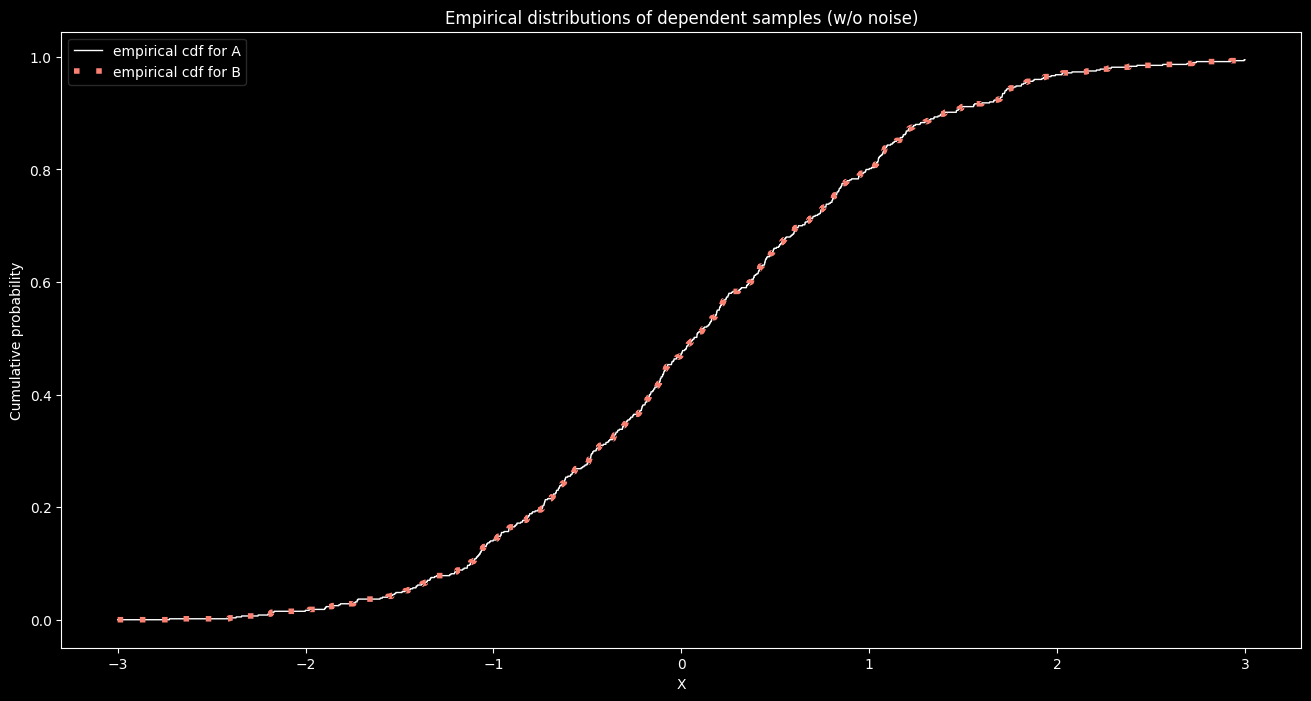

In [43]:
pyplot.figure(figsize=(16, 8))


pyplot.plot(x_axis, emp_cdf_X, color = 'white', linestyle = '-',
            linewidth=1.0, label='empirical cdf for A')
pyplot.plot(x_axis, emp_cdf_Y, color = 'salmon', linestyle = (0, (1, 3)),
            linewidth=4.0, label='empirical cdf for B')

pyplot.legend(loc='best')
pyplot.title("Empirical distributions of dependent samples (w/o noise)")
pyplot.xlabel("X")
pyplot.ylabel("Cumulative probability")

pyplot.show()

Видим, что график эмпирического распределения одной выборки находится в точности под графиком другой выборки.

### Общий случай проверки критерия для зависимых выборок

Давайте теперь посмотрим, что же происходит, когда распределения шума одинаковые, но не принимают константное значение.

В качестве распределений будем брать распределения из семейства нормальных, поскольку их удобно складывать.

Возьмем $$\mathcal{P}_{\it{\text{init}}} \sim \mathcal{N}(0,4^2),$$ 
$$\mathcal{P}_{\it{\text{noise}}_X} \sim \mathcal{N}(0, 3^2),$$
$$\mathcal{P}_{\it{\text{noise}}_Y} \sim \mathcal{N}(0, 3^2).$$ 

Получается, что $$X \sim \mathcal{P}_{\it{\text{init}}} + \mathcal{P}_{\it{\text{noise}}_X} = \mathcal{N}(0, 3^2) + \mathcal{N}(0,4^2) = \mathcal{N}(0, 5^2),$$
$$Y \sim \mathcal{P}_{\it{\text{init}}} + \mathcal{P}_{\it{\text{noise}}_Y} = \mathcal{N}(0, 3^2) + \mathcal{N}(0,4^2) = \mathcal{N}(0, 5^2)$$

Выборки $X$ и $Y$ одинаково распределены и зависимы. Нулевая гипотеза выполнена.

In [44]:
(positive_rate,
 confint_left_bound,
 confint_right_bound) = gen_monte_carlo_exp_for_ks_dependent_samples(n = 600,
                                                                     alpha = 0.05,
                                                                     N_runs = 10000, 
                                                                     init_dist = norm(0,4),
                                                                     noise_dist_X  = norm(0,3),
                                                                     noise_dist_Y =  norm(0,3))

print('FPR: ', positive_rate)
print('FPR confint: ', (confint_left_bound, confint_right_bound))

FPR:  0.0048
FPR confint:  (0.0036224922338521153, 0.006357819752465983)


Видим, что $\it{\text{FPR}}$ также очень близок к 0. Давайте нарисуем эмпирические распределения, чтобы поближе посмотреть, что происходит.

In [45]:
x_axis = numpy.arange(start=-15, stop=15, step=0.001)

# аппроксимируем CDF распределения, из которого семплирована наша выборка
# эмпирическая функция распределения:
init_sample = norm(0,4).rvs(600)
X = init_sample+norm(0,3).rvs(600)
Y = init_sample+norm(0,3).rvs(600)

emp_cdf_X = []
emp_cdf_Y = []
for x in x_axis:
    cdf_X= sum([int(b <= x) for b in X]) / len(X)
    emp_cdf_X.append(cdf_X)
    cdf_Y = sum([int(b <= x) for b in Y]) / len(Y)
    emp_cdf_Y.append(cdf_Y)

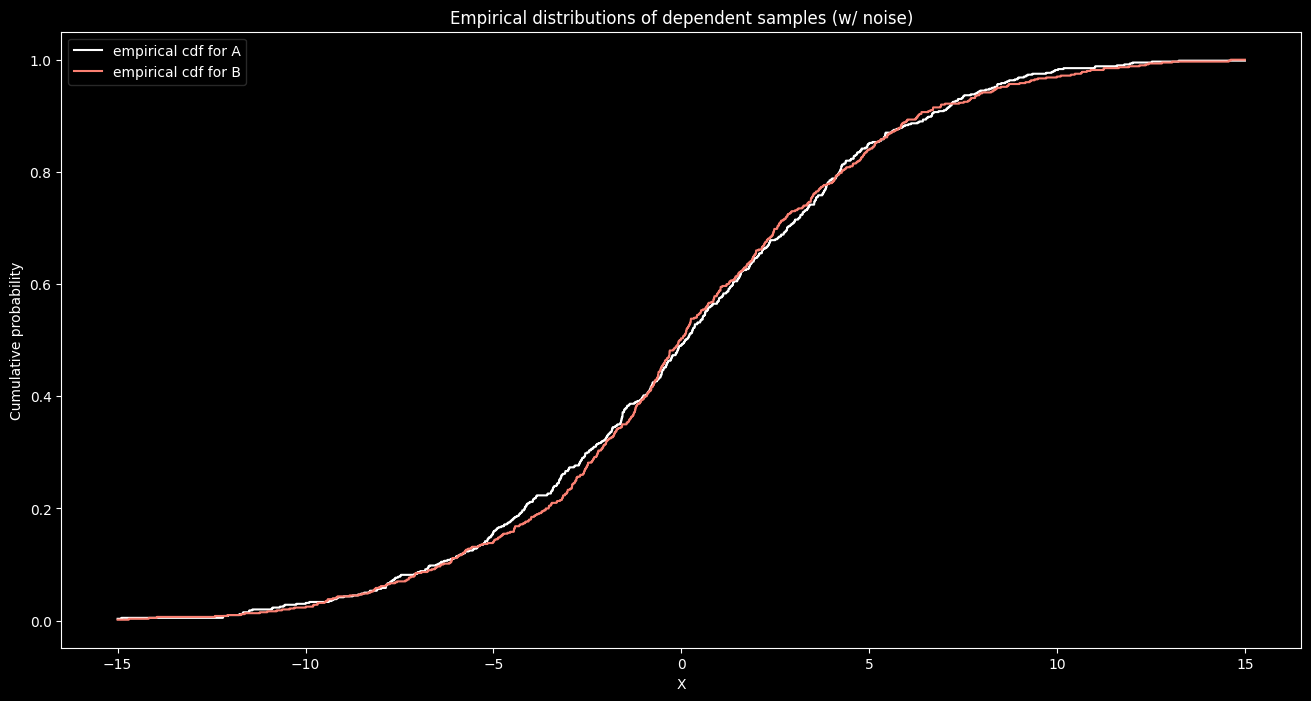

In [46]:
pyplot.figure(figsize=(16, 8))


pyplot.plot(x_axis, emp_cdf_X, color='white', label='empirical cdf for A')
pyplot.plot(x_axis, emp_cdf_Y, color='salmon', label='empirical cdf for B')

pyplot.legend(loc='best')
pyplot.title("Empirical distributions of dependent samples (w/ noise)")
pyplot.xlabel("X")
pyplot.ylabel("Cumulative probability")

pyplot.show()

Эмпирические функции распределения отличаются слабо, поэтому нулевая гипотеза при проверке критерием для зависимых выборок редко отвергается.

### Сравнение критерия Колмогорова-Смирнова для зависимых и независимых выборок

Давайте теперь сравним результаты АА тестов: какой FPR и мощность в зависимости от размера выборки получится для 
1. независимых выборок $$X, Y \sim \mathcal{N}(0, 5^2)$$
2. зависимых выборок из предыдущего пункта: $$X \sim \mathcal{P}_{\it{\text{init}}} + \mathcal{P}_{\it{\text{noise}}_X} = \mathcal{N}(0, 3^2) + \mathcal{N}(0,4^2) = \mathcal{N}(0, 5^2),$$
$$Y \sim \mathcal{P}_{\it{\text{init}}} + \mathcal{P}_{\it{\text{noise}}_Y} = \mathcal{N}(0, 3^2) + \mathcal{N}(0,4^2) =  \mathcal{N}(0, 5^2),$$
где реализация выборки из распределения $\mathcal{P}_{\it{\text{init}}}$ общая для $X$ и $Y$.

#### Сравнение $\it{\text{FPR}}$

In [47]:
FPR_list_independent = []
FPR_list_dependent = []

# перебираем размер выборки с логарифмическим шагом
for i in tqdm(numpy_ceil(numpy.geomspace(50, 6000, 10))):  
    mmk_res_independent = gen_monte_carlo_exp_for_ks(n = i, m = i, 
                                                     alpha = 0.05, 
                                                     N_runs = 10000,
                                                     latent_dist_X = norm(0, 5),
                                                     latent_dist_Y = norm(0, 5))
    FPR_list_independent.append([i, mmk_res_independent])
    
    mmk_res_dependent = gen_monte_carlo_exp_for_ks_dependent_samples(n = i,
                                                                     alpha = 0.05,
                                                                     N_runs = 10000,
                                                                     init_dist = norm(0,4),
                                                                     noise_dist_X  = norm(0,3),
                                                                     noise_dist_Y =  norm(0,3))
    FPR_list_dependent.append([i, mmk_res_dependent])

100%|██████████| 10/10 [02:56<00:00, 17.62s/it]


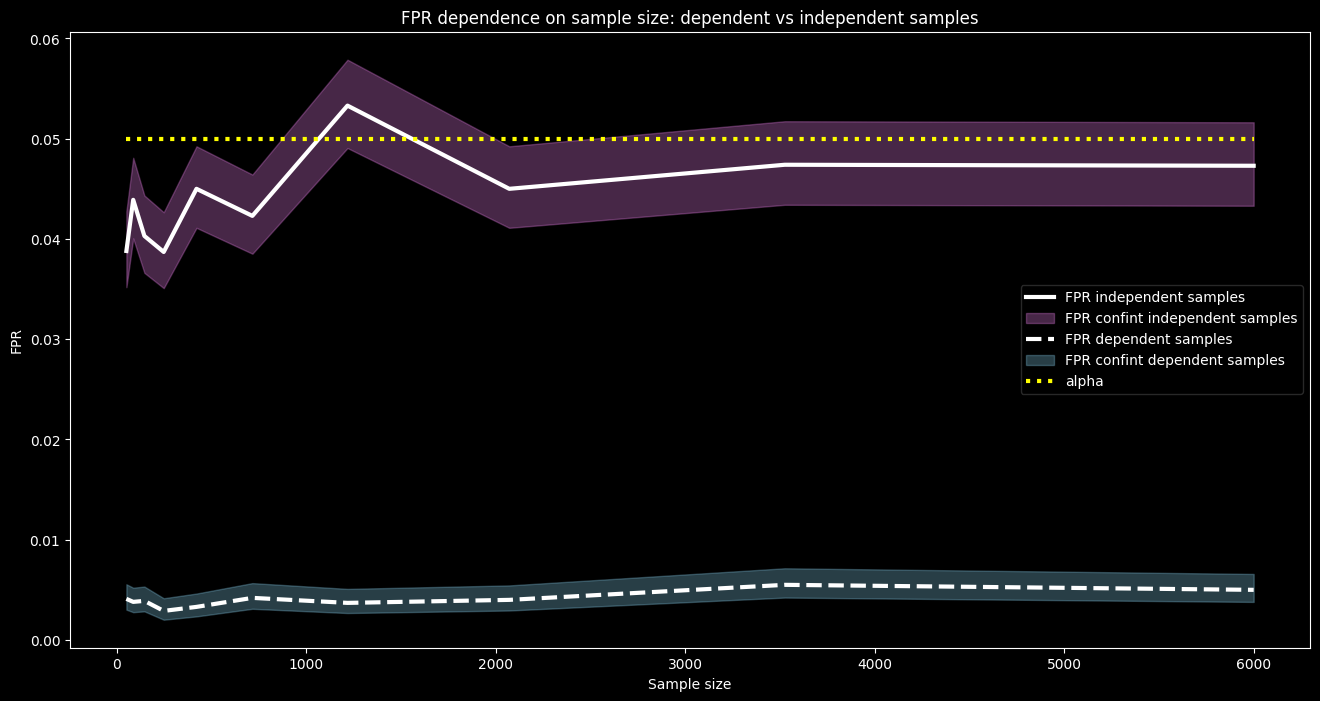

In [58]:
pyplot.figure(figsize=(16, 8))


pyplot.plot([elem[0] for elem in FPR_list_independent],
            [elem[1].positive_rate for elem in FPR_list_independent],
            color = 'white', linewidth=3.0, label='FPR independent samples')
pyplot.fill_between([elem[0] for elem in FPR_list_independent],
                    [elem[1].confint_left_bound for elem in FPR_list_independent],
                    [elem[1].confint_right_bound for elem in FPR_list_independent],
                    color = 'violet', alpha = 0.3, 
                    label='FPR confint independent samples')

pyplot.plot([elem[0] for elem in FPR_list_dependent],
            [elem[1].positive_rate for elem in FPR_list_dependent],
            color = 'white', linestyle = 'dashed', linewidth=3.0,
            label='FPR dependent samples')
pyplot.fill_between([elem[0] for elem in FPR_list_dependent],
                    [elem[1].confint_left_bound for elem in FPR_list_dependent],
                    [elem[1].confint_right_bound for elem in FPR_list_dependent],
                    color = 'skyblue', alpha = 0.3,
                    label='FPR confint dependent samples')

pyplot.plot([elem[0] for elem in FPR_list_independent],
            numpy.array([0.05]*len(FPR_list_independent)),
            color = 'yellow', linestyle = 'dotted',
            linewidth=3.0, label='alpha')

pyplot.legend(loc='best')
pyplot.title("FPR dependence on sample size: dependent vs independent samples")
pyplot.xlabel("Sample size")
pyplot.ylabel("FPR")

pyplot.show()

**Вывод: видим низкий $\it{\text{FPR}}$ для зависимых выборок. Доверительный интервал для $\it{\text{FPR}}$ не включает $\alpha$ даже для большого размера выборки. Значит, мы будем терять в мощности критерия.**

#### Сравнение мощности

По низкому $\it{\text{FPR}}$ для зависимых выборок мы сделали вывод о том, что мы будем терять в мощности. Давайте теперь явно проверим, насколько существенны эти потери. Поменяем шум для распределения $Y$ на $$\mathcal{P}_{\it{\text{noise}}_Y} \sim \mathcal{N}(0, 2^2).$$  Тогда выборка $Y$ будет порождена случайной величиной, распределенной как $\mathcal{N}(0, 2^2) + \mathcal{N}(0, 4^2) = \mathcal{N}(0, 20)$

In [49]:
TPR_list_independent = []
TPR_list_dependent = []

# перебираем размер выборки с логарифмическим шагом
for i in tqdm(numpy_ceil(numpy.geomspace(50, 6000, 10))):
    
    mmk_res_independent = gen_monte_carlo_exp_for_ks(n = i, m = i,
                                                     alpha = 0.05,
                                                     N_runs = 10000,
                                                     latent_dist_X = norm(0, 5),
                                                     latent_dist_Y = norm(0, 2*math.sqrt(5)))
    TPR_list_independent.append([i, mmk_res_independent])
    
    mmk_res_dependent = gen_monte_carlo_exp_for_ks_dependent_samples(n = i, 
                                                                     alpha = 0.05,
                                                                     N_runs = 10000,
                                                                     init_dist = norm(0,4),
                                                                     noise_dist_X  = norm(0,3),
                                                                     noise_dist_Y =  norm(0,2))
    TPR_list_dependent.append([i, mmk_res_dependent])

100%|██████████| 10/10 [02:57<00:00, 17.76s/it]


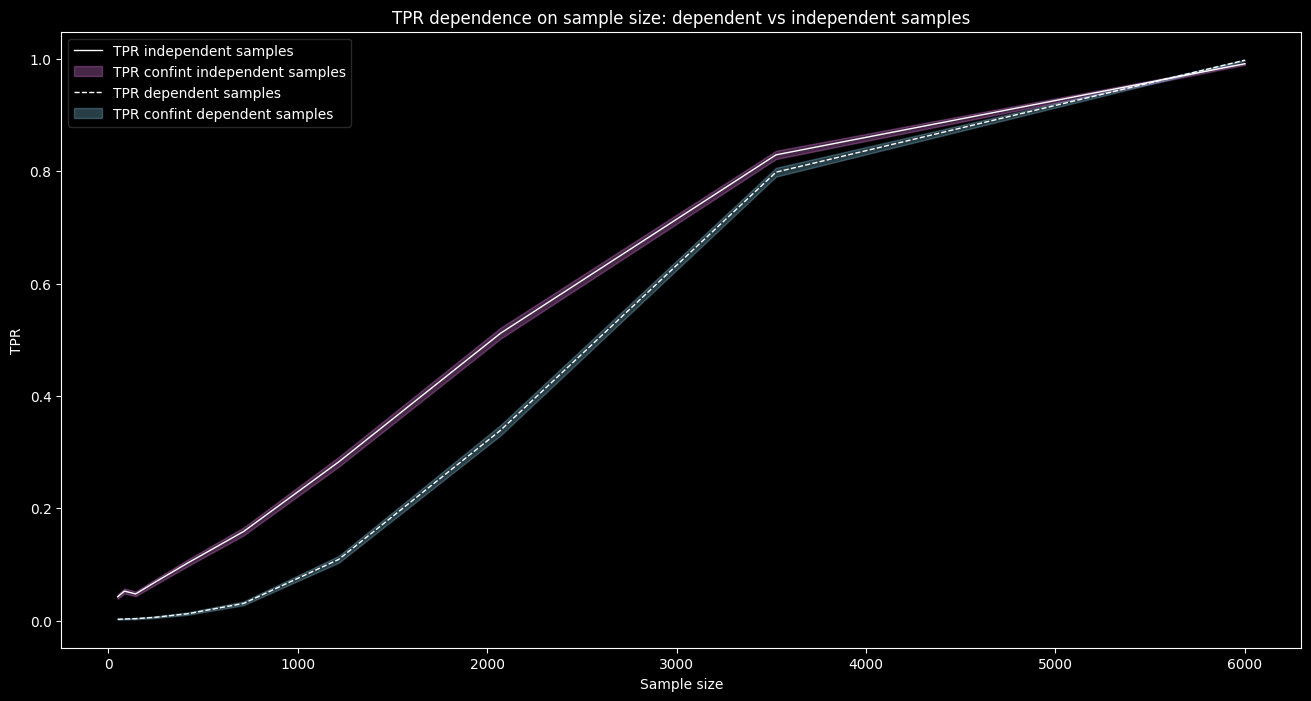

In [61]:
pyplot.figure(figsize=(16, 8))


pyplot.plot([elem[0] for elem in TPR_list_independent],
            [elem[1].positive_rate for elem in TPR_list_independent],
            color = 'white', linewidth=1.0, label='TPR independent samples')
pyplot.fill_between([elem[0] for elem in TPR_list_independent],
                    [elem[1].confint_left_bound for elem in TPR_list_independent],
                    [elem[1].confint_right_bound for elem in TPR_list_independent],
                    color = 'violet', alpha = 0.3,
                    label='TPR confint independent samples')

pyplot.plot([elem[0] for elem in TPR_list_dependent],
            [elem[1].positive_rate for elem in TPR_list_dependent],
            color = 'white', linestyle = 'dashed',
            linewidth=1.0, label='TPR dependent samples')
pyplot.fill_between([elem[0] for elem in TPR_list_dependent],
                    [elem[1].confint_left_bound for elem in TPR_list_dependent],
                    [elem[1].confint_right_bound for elem in TPR_list_dependent],
                    color = 'skyblue', alpha = 0.3, 
                    abel='TPR confint dependent samples')

pyplot.legend(loc='best')
pyplot.title("TPR dependence on sample size: dependent vs independent samples")
pyplot.xlabel("Sample size")
pyplot.ylabel("TPR")

pyplot.show()

**Вывод: для зависимых выборок мы существенно теряем в мощности критерия по сравнению с независимыми. Несмотря на это, мощность все равно стремится к 1 с увеличением выборки. Критерий все равно валиден, и может помочь обнаружить эффект.**

Если вам встретится задача с зависимостью, можно попробовать провести AA-тест, и посмотреть, наcколько $\it{\text{FPR}}$ будет близок к $\alpha$. Если $\it{\text{FPR}}$ сильно занижен, лучше применить другой критерий.

## Выводы

Давайте подведем итог, что же мы сегодня узнали?

Вывели критерий Колмогорова-Смирнова:
- Научились проверять, принадлежат ли две выборки одному распределению (при условии что выборки независимые и получены из непрерывных распределений).

Протестировали применимость критерия для разных размеров выборки:
- Получилось, что с $n, m ≈ 1000$ наблюдаемый $\it{\text{FPR}}$ не отличается от заявленной $\alpha$. 
- Для меньшего размера выборки критерий применять также можно, но $\it{\text{FPR}}$ будет заниженным, что оказывает эффект на мощность критерия.
- При увеличении размера выборки мощность стремится к 1.

Протестировали применимость критерия для зависимых выборок:
- Критерий для зависимых выборок корректен, но $\it{\text{FPR}}$ ниже $\alpha$. 
- Мы теряем в мощности по сравнению со случаем независимых выборок, но критерий все равно применим.
- При увеличении размера выборки мощность стремится к 1.

## P.S.: важное замечание по применимости критериев однородности

Мы целую лекцию разбирались с критерием Колмогорова-Смирнова, но в реальной практике аналитика данных критерии однородности встречаются редко. 

Причина этого заключается в том, что аналитика как правило интересует количественная характеристика изменения распределения метрики. Чаще нам нужно будет понять, изменилось ли среднее всей выборки, либо среднее в каком-то разрезе?

Результатом применения критерия однородности Колмогорова-Смирнова будет наличие изменения в распределении, без ответа на вопрос "а какое именно изменение произошло?". Стали ли тяжелее хвосты или произошел сдвиг распределения? На эти вопросы критерий Колмогорова-Смирнова ответить не сможет, в отличие от T-теста.

При этом модельной задачкой в этой методичке была задачка из области медицины. В сфере медицины такой критерий будет более полезным, потому что наличие эффекта определенного лекарства на рассматриваемую метрику уже будет являться результатом: об этом как минимум стоит написать на упаковке лекарства.

Помимо знания о том, в каких случаях критерий применим, вам также потребуется знание, в каких случаях он не применим. Поэтому, в следующий раз, когда кто-то вам скажет использовать критерий однородности Колмогорова-Смирнова в какой-то задаче, стоит хорошо подумать, прежде чем это сделать.